# Data augmentation

### Imports

In [1]:
import os
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib

import scipy.ndimage
from scipy.ndimage import rotate, gaussian_filter, map_coordinates, gaussian_filter as nd_gaussian_filter

from imblearn.over_sampling import SMOTE

import random
import time

# import cv2

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader

# from tqdm import tqdm

## Training GAN

In [ ]:
csv_path   = "Dataset/CSV/processed_data.csv"
imgs_dir = "Dataset/Images/Processed_NIfTI"
save_model_path  = "Vanilla_GAN"
os.makedirs(save_model_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# -----------------------------
# Dataset
# -----------------------------
class ParkinsonsDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.df = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)

        # Ensure required columns exist
        assert "PATNO" in self.df.columns, "CSV must contain PATNO in col 1"
        assert "Image Data ID" in self.df.columns, "CSV must contain 'Image Data ID' in col 3"

        # Features = columns after the 3rd column
        self.feature_cols = self.df.columns[3:]
        self.features = self.df[self.feature_cols].astype(np.float32).values


        # self.paths = []
        # rows_to_keep = []
        # for i, row in self.df.iterrows():
        #     patno = str(row["PATNO"])
        #     img_id = str(row["Image Data ID"])
        #     p = self.root_dir / patno / f"{img_id}.nii.gz"
        #     if p.exists():
        #         self.paths.append(p)
        #         rows_to_keep.append(i)
        # # keep only rows with existing images
        # self.df = self.df.iloc[rows_to_keep].reset_index(drop=True)
        # self.features = self.features[rows_to_keep]

        # Directly build image paths
        self.paths = [
            self.root_dir / str(row["PATNO"]) / f"{str(row['Image Data ID'])}.nii.gz"
            for _, row in self.df.iterrows()
        ]

        print(f"[Dataset] total usable pairs: {len(self.df)}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        patno   = str(row["PATNO"])
        img_id  = str(row["Image Data ID"])
        img_path = self.root_dir / patno / f"{img_id}.nii.gz"

        vol = nib.load(str(img_path)).get_fdata().astype(np.float32)

        # Min-Max normalize z-scored volume to [-1,1]
        vmin, vmax = vol.min(), vol.max()
        if vmax > vmin:  # avoid division by zero
            vol = 2.0 * (vol - vmin) / (vmax - vmin) - 1.0
        else:
            vol = np.zeros_like(vol)  # if flat image, set to 0
            
        vol = np.expand_dims(vol, axis=0)  # (1, D, H, W) = (1, 46, 54, 14)

        cond = self.features[idx].astype(np.float32)

        # Return tensors
        return torch.from_numpy(vol), torch.from_numpy(cond)


# -----------------------------
# Models
# -----------------------------
class UpBlock(nn.Module):
    """Upsample to a specific size with trilinear, then Conv3D+BN+ReLU."""
    def __init__(self, in_ch, out_ch, target_size):
        super().__init__()
        self.target_size = target_size
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = F.interpolate(x, size=self.target_size, mode="trilinear", align_corners=False)
        x = self.conv(x)
        return x


class Generator3D(nn.Module):
    """
    Project z|c -> (C, d0,h0,w0), then upsample in 3 steps to (46,54,14).
    Non-power-of-two handled by specifying explicit target sizes.
    """
    def __init__(self, noise_dim, cond_dim):
        super().__init__()
        self.noise_dim = noise_dim
        self.cond_dim  = cond_dim

        self.fc = nn.Linear(noise_dim + cond_dim, 256 * 6 * 7 * 4)  # seed volume 256x6x7x4
        self.up1 = UpBlock(256, 128, target_size=(12, 14, 6))
        self.up2 = UpBlock(128, 64,  target_size=(24, 27, 10))
        self.up3 = UpBlock(64,  32,  target_size=(46, 54, 14))
        self.out = nn.Conv3d(32, 1, kernel_size=3, padding=1)

    def forward(self, z, cond):
        x = torch.cat([z, cond], dim=1)                 # (B, z+c)
        x = self.fc(x)                                  # (B, 256*6*7*4)
        x = x.view(x.size(0), 256, 6, 7, 4)             # (B, 256, 6,7,4)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.out(x)
        x = torch.tanh(x)                            # (B,1,46,54,14) in [-1,1]
        return x


class Discriminator3D(nn.Module):
    """
    Downsample with strided convs to a small grid, global pool, fuse with condition.
    """
    def __init__(self, cond_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 32, 4, stride=2, padding=1),     # -> ~23x27x7
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(32, 64, 4, stride=2, padding=1),    # -> ~12x14x4
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, 4, stride=2, padding=1),   # -> ~6x7x2
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, 3, stride=1, padding=1),  # keep size
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.gap = nn.AdaptiveAvgPool3d((1,1,1))
        self.img_fc  = nn.Linear(256, 256)
        self.cond_fc = nn.Linear(cond_dim, 256)
        self.out_fc  = nn.Linear(256, 1)

    def forward(self, x, cond):
        h = self.conv(x)               # (B,256,d,h,w)
        h = self.gap(h).flatten(1)     # (B,256)
        hi = self.img_fc(h)            # (B,256)
        hc = self.cond_fc(cond)        # (B,256)
        fused = F.leaky_relu(hi + hc, 0.2)
        return torch.sigmoid(self.out_fc(fused))         # (B,1)


# -----------------------------
# Utilities
# -----------------------------
def save_nii(volume_tensor, ref_nii_path, out_path):
    """
    Save generated tensor (B,1,46,54,14) or (1,46,54,14) as NIfTI, 
    using reference affine/header where possible.
    """
    vol = volume_tensor.detach().cpu().numpy()
    if vol.ndim == 5:  # (B,1,D,H,W) -> first sample
        vol = vol[0, 0]
    elif vol.ndim == 4:  # (1,D,H,W)
        vol = vol[0]
    else:
        raise ValueError("Unexpected volume tensor shape")

    # Try to reuse affine/header from a real NIfTI
    try:
        ref = nib.load(ref_nii_path)
        affine, header = ref.affine, ref.header
    except Exception:
        affine, header = np.eye(4), None

    nib.save(nib.Nifti1Image(vol.astype(np.float32), affine=affine, header=header), out_path)


# -----------------------------
# Training
# -----------------------------
def train_gan(
    csv_file,
    root_dir,
    epochs=50,
    batch_size=4,
    noise_dim=128,
    lr=2e-4,
    patience=10,
    max_batches_per_epoch=None
):
    ds = ParkinsonsDataset(csv_file, root_dir)
    cond_dim = ds.features.shape[1]
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)  # safer with 0 workers on Windows

    G = Generator3D(noise_dim, cond_dim).to(device)
    D = Discriminator3D(cond_dim).to(device)

    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    bce  = nn.BCELoss()

    # store losses
    d_losses, g_losses = [], []

    # early stopping vars
    best_g_loss = float("inf")
    best_epoch  = 0
    patience_counter = 0

    for epoch in range(1, epochs+1):
        G.train(); D.train()
        d_running, g_running = 0.0, 0.0

        # tqdm progress bar for batches
        pbar = tqdm(enumerate(dl, start=1), total=len(dl), desc=f"Epoch {epoch}/{epochs}", ncols=100)

        for it, (real, cond) in pbar:
            real = real.to(device)
            cond = cond.to(device)
            B = real.size(0)

            real_lbl = torch.ones(B, 1, device=device)
            fake_lbl = torch.zeros(B, 1, device=device)

            # ---- Train D ----
            noise = torch.randn(B, noise_dim, device=device)
            fake = G(noise, cond).detach()

            out_real = D(real, cond)
            out_fake = D(fake, cond)

            d_loss = bce(out_real, real_lbl) + bce(out_fake, fake_lbl)
            optD.zero_grad()
            d_loss.backward()
            optD.step()

            # ---- Train G ----
            noise = torch.randn(B, noise_dim, device=device)
            fake = G(noise, cond)
            out_fake = D(fake, cond)
            g_loss = bce(out_fake, real_lbl)

            optG.zero_grad()
            g_loss.backward()
            optG.step()

            d_running += d_loss.item()
            g_running += g_loss.item()

            # update tqdm bar
            pbar.set_postfix({
                "D_loss": f"{d_loss.item():.4f}",
                "G_loss": f"{g_loss.item():.4f}"
            })

            if max_batches_per_epoch and it >= max_batches_per_epoch:
                break

        d_epoch = d_running / it
        g_epoch = g_running / it
        d_losses.append(d_epoch)
        g_losses.append(g_epoch)

        print(f"\nEpoch {epoch:03d} | D: {d_epoch:.4f} | G: {g_epoch:.4f}")

        # Early Stopping Check for the Generator
        if g_epoch < best_g_loss:
            best_g_loss = g_epoch
            best_epoch  = epoch
            patience_counter = 0
            os.makedirs(save_model_path + "/models", exist_ok=True)
            torch.save(G.state_dict(), f"{save_model_path}/models/Generator_best.pt")
            torch.save(D.state_dict(), f"{save_model_path}/models/Discriminator_best.pt")
            print(f"✅ New best model saved at epoch {epoch} (G_loss={g_epoch:.4f})\n")
        else:
            patience_counter += 1
            print(f"⚠️  No improvement. Patience {patience_counter}/{patience}\n")
            if patience_counter >= patience:
                print(f"\n⏹️ Early stopping at epoch {epoch}. Best epoch was {best_epoch} with G_loss={best_g_loss:.4f}\n")
                break
    
    
    # ---- Plot & save training curves ----
    os.makedirs(save_model_path + "/plots", exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), d_losses, label="Discriminator Loss")
    plt.plot(range(1, epochs+1), g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_model_path}/plots/training_curves.png")
    plt.close()
    print("\nTraining curves saved.\n")

    print("✅ Vanilla_GAN Training finished.")
    
    return G, D

In [ ]:
# -----------------------------
# Run
# -----------------------------
G, D = train_gan(
    csv_file=csv_path,
    root_dir=imgs_dir,
    epochs=80, # 50-100 (use 80)
    batch_size=4,
    noise_dim=128,
    lr=1e-4,
    patience=20,
    max_batches_per_epoch=None  # or e.g. 200 for quicker passes
)

[Dataset] total usable pairs: 986


Epoch 1/80: 100%|███████████████████| 247/247 [06:39<00:00,  1.62s/it, D_loss=1.3525, G_loss=0.6832]



Epoch 001 | D: 1.2642 | G: 0.7986
✅ New best model saved at epoch 1 (G_loss=0.7986)



Epoch 2/80: 100%|███████████████████| 247/247 [06:52<00:00,  1.67s/it, D_loss=1.0734, G_loss=1.1480]



Epoch 002 | D: 1.2518 | G: 0.8566
⚠️  No improvement. Patience 1/80



Epoch 3/80: 100%|███████████████████| 247/247 [06:53<00:00,  1.67s/it, D_loss=0.8053, G_loss=0.6661]



Epoch 003 | D: 1.1992 | G: 0.9191
⚠️  No improvement. Patience 2/80



Epoch 4/80: 100%|███████████████████| 247/247 [06:37<00:00,  1.61s/it, D_loss=0.6836, G_loss=0.7601]



Epoch 004 | D: 1.0080 | G: 1.1854
⚠️  No improvement. Patience 3/80



Epoch 5/80: 100%|███████████████████| 247/247 [06:58<00:00,  1.69s/it, D_loss=1.3263, G_loss=1.9305]



Epoch 005 | D: 1.0781 | G: 1.1654
⚠️  No improvement. Patience 4/80



Epoch 6/80: 100%|███████████████████| 247/247 [06:46<00:00,  1.65s/it, D_loss=0.9934, G_loss=0.2995]



Epoch 006 | D: 0.9573 | G: 1.3360
⚠️  No improvement. Patience 5/80



Epoch 7/80: 100%|███████████████████| 247/247 [06:42<00:00,  1.63s/it, D_loss=0.6781, G_loss=1.3948]



Epoch 007 | D: 1.0871 | G: 1.1593
⚠️  No improvement. Patience 6/80



Epoch 8/80: 100%|███████████████████| 247/247 [06:16<00:00,  1.52s/it, D_loss=1.2773, G_loss=1.3807]



Epoch 008 | D: 1.1036 | G: 1.1339
⚠️  No improvement. Patience 7/80



Epoch 9/80: 100%|███████████████████| 247/247 [06:16<00:00,  1.52s/it, D_loss=1.8007, G_loss=1.0763]



Epoch 009 | D: 1.1336 | G: 1.0519
⚠️  No improvement. Patience 8/80



Epoch 10/80: 100%|██████████████████| 247/247 [06:13<00:00,  1.51s/it, D_loss=1.3420, G_loss=0.8506]



Epoch 010 | D: 1.1305 | G: 1.0505
⚠️  No improvement. Patience 9/80



Epoch 11/80: 100%|██████████████████| 247/247 [06:19<00:00,  1.54s/it, D_loss=1.1149, G_loss=1.0040]



Epoch 011 | D: 1.1291 | G: 1.0323
⚠️  No improvement. Patience 10/80



Epoch 12/80: 100%|██████████████████| 247/247 [06:18<00:00,  1.53s/it, D_loss=1.1167, G_loss=1.3893]



Epoch 012 | D: 1.1428 | G: 1.0535
⚠️  No improvement. Patience 11/80



Epoch 13/80: 100%|██████████████████| 247/247 [06:18<00:00,  1.53s/it, D_loss=1.1030, G_loss=1.1896]



Epoch 013 | D: 1.1004 | G: 1.0442
⚠️  No improvement. Patience 12/80



Epoch 14/80: 100%|██████████████████| 247/247 [06:15<00:00,  1.52s/it, D_loss=1.8216, G_loss=1.0358]



Epoch 014 | D: 1.0927 | G: 1.1114
⚠️  No improvement. Patience 13/80



Epoch 15/80: 100%|██████████████████| 247/247 [06:16<00:00,  1.53s/it, D_loss=1.2557, G_loss=1.2480]



Epoch 015 | D: 1.1130 | G: 1.0723
⚠️  No improvement. Patience 14/80



Epoch 16/80: 100%|██████████████████| 247/247 [06:33<00:00,  1.59s/it, D_loss=0.8144, G_loss=0.9613]



Epoch 016 | D: 1.0791 | G: 1.1020
⚠️  No improvement. Patience 15/80



Epoch 17/80: 100%|██████████████████| 247/247 [06:26<00:00,  1.56s/it, D_loss=2.1487, G_loss=1.4628]



Epoch 017 | D: 1.0933 | G: 1.0924
⚠️  No improvement. Patience 16/80



Epoch 18/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.7883, G_loss=0.9477]



Epoch 018 | D: 1.0196 | G: 1.2141
⚠️  No improvement. Patience 17/80



Epoch 19/80: 100%|██████████████████| 247/247 [06:24<00:00,  1.56s/it, D_loss=0.9482, G_loss=0.6205]



Epoch 019 | D: 1.0551 | G: 1.1785
⚠️  No improvement. Patience 18/80



Epoch 20/80: 100%|██████████████████| 247/247 [06:26<00:00,  1.57s/it, D_loss=1.0390, G_loss=1.8050]



Epoch 020 | D: 1.0152 | G: 1.1916
⚠️  No improvement. Patience 19/80



Epoch 21/80: 100%|██████████████████| 247/247 [06:29<00:00,  1.58s/it, D_loss=1.2931, G_loss=1.0922]



Epoch 021 | D: 1.0106 | G: 1.2061
⚠️  No improvement. Patience 20/80



Epoch 22/80: 100%|██████████████████| 247/247 [06:25<00:00,  1.56s/it, D_loss=0.3738, G_loss=1.5041]



Epoch 022 | D: 0.9711 | G: 1.2957
⚠️  No improvement. Patience 21/80



Epoch 23/80: 100%|██████████████████| 247/247 [06:24<00:00,  1.56s/it, D_loss=0.9367, G_loss=0.3867]



Epoch 023 | D: 1.0218 | G: 1.2065
⚠️  No improvement. Patience 22/80



Epoch 24/80: 100%|██████████████████| 247/247 [06:24<00:00,  1.56s/it, D_loss=1.1406, G_loss=0.8750]



Epoch 024 | D: 0.9460 | G: 1.2802
⚠️  No improvement. Patience 23/80



Epoch 25/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=1.3633, G_loss=1.3217]



Epoch 025 | D: 0.9366 | G: 1.3035
⚠️  No improvement. Patience 24/80



Epoch 26/80: 100%|██████████████████| 247/247 [06:28<00:00,  1.57s/it, D_loss=0.4034, G_loss=1.8727]



Epoch 026 | D: 0.9186 | G: 1.3350
⚠️  No improvement. Patience 25/80



Epoch 27/80: 100%|██████████████████| 247/247 [06:28<00:00,  1.57s/it, D_loss=0.5180, G_loss=1.5458]



Epoch 027 | D: 0.8696 | G: 1.3910
⚠️  No improvement. Patience 26/80



Epoch 28/80: 100%|██████████████████| 247/247 [06:26<00:00,  1.56s/it, D_loss=0.2724, G_loss=1.7786]



Epoch 028 | D: 0.8675 | G: 1.4394
⚠️  No improvement. Patience 27/80



Epoch 29/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.4709, G_loss=0.8883]



Epoch 029 | D: 0.8711 | G: 1.4670
⚠️  No improvement. Patience 28/80



Epoch 30/80: 100%|██████████████████| 247/247 [06:29<00:00,  1.58s/it, D_loss=0.5466, G_loss=2.7707]



Epoch 030 | D: 0.8720 | G: 1.4639
⚠️  No improvement. Patience 29/80



Epoch 31/80: 100%|██████████████████| 247/247 [06:38<00:00,  1.61s/it, D_loss=1.4324, G_loss=1.1845]



Epoch 031 | D: 0.8353 | G: 1.4985
⚠️  No improvement. Patience 30/80



Epoch 32/80: 100%|██████████████████| 247/247 [06:31<00:00,  1.59s/it, D_loss=0.4632, G_loss=2.4215]



Epoch 032 | D: 0.7806 | G: 1.5638
⚠️  No improvement. Patience 31/80



Epoch 33/80: 100%|██████████████████| 247/247 [06:30<00:00,  1.58s/it, D_loss=0.4125, G_loss=1.5070]



Epoch 033 | D: 0.7943 | G: 1.6103
⚠️  No improvement. Patience 32/80



Epoch 34/80: 100%|██████████████████| 247/247 [06:29<00:00,  1.58s/it, D_loss=0.1426, G_loss=0.9213]



Epoch 034 | D: 0.7673 | G: 1.6246
⚠️  No improvement. Patience 33/80



Epoch 35/80: 100%|██████████████████| 247/247 [06:30<00:00,  1.58s/it, D_loss=1.0956, G_loss=2.3737]



Epoch 035 | D: 0.7593 | G: 1.6801
⚠️  No improvement. Patience 34/80



Epoch 36/80: 100%|██████████████████| 247/247 [06:28<00:00,  1.57s/it, D_loss=1.5824, G_loss=0.4121]



Epoch 036 | D: 0.8120 | G: 1.6662
⚠️  No improvement. Patience 35/80



Epoch 37/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.5614, G_loss=2.4058]



Epoch 037 | D: 0.7666 | G: 1.6343
⚠️  No improvement. Patience 36/80



Epoch 38/80: 100%|██████████████████| 247/247 [06:28<00:00,  1.57s/it, D_loss=1.8356, G_loss=0.9410]



Epoch 038 | D: 0.7813 | G: 1.6941
⚠️  No improvement. Patience 37/80



Epoch 39/80: 100%|██████████████████| 247/247 [06:29<00:00,  1.58s/it, D_loss=1.1622, G_loss=0.8749]



Epoch 039 | D: 0.7766 | G: 1.6447
⚠️  No improvement. Patience 38/80



Epoch 40/80: 100%|██████████████████| 247/247 [06:28<00:00,  1.57s/it, D_loss=1.5534, G_loss=2.3156]



Epoch 040 | D: 0.7036 | G: 1.7818
⚠️  No improvement. Patience 39/80



Epoch 41/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.7221, G_loss=1.2505]



Epoch 041 | D: 0.7036 | G: 1.8431
⚠️  No improvement. Patience 40/80



Epoch 42/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.5629, G_loss=3.2532]



Epoch 042 | D: 0.6628 | G: 1.9157
⚠️  No improvement. Patience 41/80



Epoch 43/80: 100%|██████████████████| 247/247 [06:26<00:00,  1.56s/it, D_loss=1.6963, G_loss=0.3184]



Epoch 043 | D: 0.6497 | G: 1.9017
⚠️  No improvement. Patience 42/80



Epoch 44/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.7037, G_loss=1.3903]



Epoch 044 | D: 0.7070 | G: 1.8866
⚠️  No improvement. Patience 43/80



Epoch 45/80: 100%|██████████████████| 247/247 [06:27<00:00,  1.57s/it, D_loss=0.9241, G_loss=1.0080]



Epoch 045 | D: 0.6642 | G: 1.9087
⚠️  No improvement. Patience 44/80



Epoch 46/80:  48%|████████▋         | 119/247 [03:11<03:26,  1.61s/it, D_loss=0.4545, G_loss=1.1319]


KeyboardInterrupt: 

## Augmenting Images

### test

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import nibabel as nib

# ---- Load trained Generator ----
noise_dim = 128  # same as training
csv_file = csv_path
root_dir = imgs_dir
save_model_path  = "Vanilla_GAN"
save_dir = "generated_images"
os.makedirs(save_dir, exist_ok=True)

# Reload dataset & Generator
ds = ParkinsonsDataset(csv_file, root_dir)
cond_dim = ds.features.shape[1]

G = Generator3D(noise_dim, cond_dim).to(device)
G.load_state_dict(torch.load(f"{save_model_path}/models/Generator_best.pt", map_location=device))
G.eval()

# ---- Pick 5 random rows from CSV ----
df = pd.read_csv(csv_file)
sample_rows = df.sample(5, random_state=42)  # fixed seed for reproducibility
conds = torch.from_numpy(sample_rows.drop(columns=["PATNO", "EVENT_ID", "Image Data ID"]).values.astype(np.float32)).to(device)

# ---- Generate images ----
with torch.no_grad():
    noise = torch.randn(5, noise_dim, device=device)
    fake_imgs = G(noise, conds).cpu().numpy()  # shape: (5, 1, 46, 54, 14)

# ---- Save each as NIfTI ----
for i, img in enumerate(fake_imgs):
    img = np.squeeze(img)  # remove channel dimension -> (46, 54, 14)
    nii_img = nib.Nifti1Image(img, affine=np.eye(4))  # identity affine
    save_path = os.path.join(save_dir, f"generated_{i+1}.nii.gz")
    nib.save(nii_img, save_path)
    print(f"✅ Saved: {save_path}")

### real (with WGAN)

In [ ]:
# === Paths ===
csv_path = "Dataset/CSV/processed_data.csv"
imgs_dir = "Dataset/Images/Processed_NIfTI"
save_model_path  = "Vanilla_GAN"
save_csv_path = "Dataset/CSV/processed_data_augmented.csv"
save_imgs_dir = "Dataset/Images/Processed_NIfTI_augmented"
noise_dim = 128 # same as training

# Load CSV
df = pd.read_csv(csv_path)

# Target counts for each NHY
target_counts = {
    0: 50,
    1: 200,
    2: 753,  # no augmentation
    3: 100,
    4: 50
}

# Track all used IDs
existing_ids = set(df["Image Data ID"].astype(str))

def generate_unique_id(existing_ids):
    while True:
        new_id = "I" + str(random.randint(1000000, 99999999))
        if new_id not in existing_ids:
            existing_ids.add(new_id)
            return new_id

# Reload dataset & Generator
ds = ParkinsonsDataset(csv_path, imgs_dir)
cond_dim = ds.features.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"
G = Generator3D(noise_dim, cond_dim).to(device)
G.load_state_dict(torch.load(f"{save_model_path}/models/Generator_best.pt", map_location=device))

G.eval()

new_rows = []

# Loop over each NHY class and augment to target count
for nhy, target in target_counts.items():
    df_class = df[df["NHY"] == nhy].copy()
    current_count = len(df_class)

    if current_count >= target:
        # print(f"[!] NHY {nhy} already has {current_count}, target {target} → no augmentation")
        continue

    n_to_generate = target - current_count
    # print(f"[+] Augmenting NHY {nhy}: current={current_count}, target={target}, generating={n_to_generate}")

    # Create pool of image IDs for this class
    id_pool = list(df_class["Image Data ID"].astype(str))

    for i in range(n_to_generate):
        # If pool is empty, refill it with all IDs
        if not id_pool:
            id_pool = list(df_class["Image Data ID"].astype(str))
        # Pick a random ID from pool and remove it
        chosen_id = random.choice(id_pool)
        id_pool.remove(chosen_id)

        # Retrieve the row corresponding to chosen ID
        row = df_class[df_class["Image Data ID"] == chosen_id].iloc[0]

        patno = str(row["PATNO"])
        cond = row.drop(["PATNO", "EVENT_ID", "Image Data ID"]).values.astype(np.float32) #? condition is row here but df in training

        cond_tensor = torch.tensor(cond).unsqueeze(0).to(device)
        z = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_vol = G(z, cond_tensor).cpu().numpy()[0, 0]  # (D,H,W)

        new_id = generate_unique_id(existing_ids)

        # Save generated NIfTI
        patient_folder = os.path.join(save_imgs_dir, patno)
        os.makedirs(patient_folder, exist_ok=True)
        out_path = os.path.join(patient_folder, f"{new_id}.nii.gz")
        nib.save(nib.Nifti1Image(fake_vol.astype(np.float32), np.eye(4)), out_path)

        # Create new row for CSV
        new_row = row.copy()
        new_row["EVENT_ID"] = "GAN"
        new_row["Image Data ID"] = new_id
        new_rows.append(new_row)

        # if (i+1) % 5 == 0 or (i+1) == n_to_generate:
        #     print(f"   [✓] {i+1}/{n_to_generate} images generated for NHY {nhy}")


# === Append new rows and save new CSV ===
df_augmented = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
df_augmented.to_csv(save_csv_path, index=False)

print(f"✅ Generated {len(new_rows)} new images and saved into {save_imgs_dir}")
print(f"✅ New augmented CSV saved at: {save_csv_path}")


### real (with traditionnal)

#### SMOTE

In [2]:
# Seed for reproducibility
random.seed(42)
np.random.seed(42)

csv_path = "Dataset/CSV/paired_data_datscan.csv"
imgs_dir = "Dataset/datscan_images/bm3d_full/paired/Cropped_NIfTI"

save_csv_path = "Dataset/CSV/bm3d_full/paired_data_datscan_augmented.csv"
save_imgs_dir = "Dataset/datscan_images/bm3d_full/paired/Cropped_NIfTI_augmented"
os.makedirs(save_imgs_dir, exist_ok=True)


# Load CSV
df = pd.read_csv(csv_path)
print(f"[+] Loaded CSV rows: {len(df)}")
existing_ids = set(df["Image Data ID"].astype(str))

def generate_unique_id(existing_ids):
    while True:
        new_id = "I" + str(random.randint(1000000, 99999999))
        if new_id not in existing_ids:
            existing_ids.add(new_id)
            return new_id


# Define SMOTE target ratios
counts = df["NHY"].value_counts()
majority_label = counts.idxmax()
majority_count = counts.max()
print(f"[+] NHY counts before: \n{counts}\nmajority label: {majority_label}, count: {majority_count}")

ratios = {
    0: 0.25,   # small class -> 25% of majority
    1: 0.50,   # mid -> 50% of majority
    2: 1.00,   # majority (leave)
    3: 0.50,   # mid -> 50% of majority
    4: 0.25    # small -> 25% of majority
}

# Build sampling_strategy dict for SMOTE
sampling_strategy = {}
for cls, ratio in ratios.items():
    if cls == majority_label:
        continue
    desired = int(majority_count * ratio)
    current = counts.get(cls, 0)
    if desired > current:
        sampling_strategy[cls] = desired

print("[+] SMOTE sampling_strategy:", sampling_strategy)


# Prepare feature matrix for SMOTE, Keep id columns aside
id_cols = ["Image Data ID", "PATNO", "EVENT_ID"]
assert "NHY" in df.columns, "NHY label column missing"

# X keeps only feature columns (everything except id_cols + label)
feature_cols = [c for c in df.columns if c not in id_cols + ["NHY"]]
X = df[feature_cols].copy()
y = df["NHY"].copy()

# choose k_neighbors safely (SMOTE requires k_neighbors < n_samples for each minority class)
min_class_count = min([df[df["NHY"] == cls].shape[0] for cls in sampling_strategy.keys()]) if sampling_strategy else 0
k_neighbors = min(3, max(1, min_class_count - 1))  # ensure at least 1

print(f"[+] Using SMOTE k_neighbors={k_neighbors}")
if sampling_strategy:
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X, y)
else:
    # Nothing to do
    X_res, y_res = X.values, y.values

print(f"[+] After SMOTE total rows: {len(X_res)} (orig {len(X)})")

# Build df_res (features + NHY)
df_res = pd.DataFrame(X_res, columns=feature_cols)
df_res["NHY"] = y_res

# We need to detect which rows are synthetic
# imblearn preserves original samples first, then synthetic appended
# We'll assume that the first len(X) rows correspond to original samples:
orig_len = len(X)
if len(df_res) <= orig_len:
    print("[!] No synthetic samples created by SMOTE (nothing to augment).")
    df_synthetic = pd.DataFrame(columns=df_res.columns)
else:
    df_synthetic = df_res.iloc[orig_len:].copy().reset_index(drop=True)
    print(f"[+] Synthetic rows to create: {len(df_synthetic)}")



# Construct synthetic rows (tabular) and create synthetic images by augmenting a real image from same class
# create a lookup of real rows by NHY for image selection
real_by_class = {}
for nhy_label, group in df.groupby("NHY"):
    real_by_class[nhy_label] = group.reset_index(drop=True)

new_rows = []
synth_count = 0

# helper: elastic_deformation
def elastic_deformation(vol, alpha=5, sigma=3):
    """
    Apply elastic deformation on 3D volume.
    alpha: scaling factor for displacement intensity
    sigma: smoothing factor for displacement fields
    """
    random_state = np.random.RandomState(None)
    shape = vol.shape

    # Generate random displacement fields for each axis
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    # Create meshgrid coordinates and add displacements
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = (x + dx, y + dy, z + dz)

    # Map_coordinates requires the indices in flattened format
    distorted_vol = scipy.ndimage.map_coordinates(vol, indices, order=1, mode='reflect')

    return distorted_vol

def augment_volume(vol):
    # Rotation
    if random.random() < 0.5:
        angle = random.uniform(-10, 10)
        vol = scipy.ndimage.rotate(vol, angle, axes=(1,2), reshape=False, order=1, mode='nearest')

    # Translation / Shift
    if random.random() < 0.5:
        shift = np.random.uniform(-5, 5, size=3)
        vol = scipy.ndimage.shift(vol, shift, order=1, mode='nearest')
    
    # Flipping
    if random.random() < 0.5:
        vol = np.flip(vol, axis=2)  # flip left-right
    
    # Add Gaussian Noise
    if random.random() < 0.5:
        noise = np.random.normal(0, 0.03 * np.std(vol), vol.shape)
        vol = vol + noise

    ## V2
    # Bias field
    if random.random() < 0.3:
        bias = np.random.uniform(0.95, 1.05, size=vol.shape)
        vol = vol * bias
    
    # Gaussian blur
    if random.random() < 0.4:
        sigma = random.uniform(0.5, 2.0)
        vol = scipy.ndimage.gaussian_filter(vol, sigma=sigma)

    # Gamma adjustment
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        min_val = vol.min()
        vol_shifted = vol - min_val + 1e-6 # shift to positive domain
        vol = np.power(vol_shifted, gamma) + min_val - 1e-6 # shift back
    
    # Intensity scaling & shifting
    if random.random() < 0.5:
        scale = random.uniform(0.9, 1.1)
        shift = random.uniform(-0.05, 0.05)
        vol = vol * scale + shift
    
    # Elastic deformation
    if random.random() < 0.3:
        vol = elastic_deformation(vol, alpha=5, sigma=3)
        
    return vol


for idx in range(len(df_synthetic)):
    synth_row = df_synthetic.iloc[idx]
    nhy = int(synth_row["NHY"])

    # pick a real example from same class
    if nhy not in real_by_class or len(real_by_class[nhy]) == 0:
        print(f"[!] No real example to pick for NHY={nhy}, skipping synthetic image creation.")
        continue

    real_row = real_by_class[nhy].sample(n=1).iloc[0]
    real_patno = str(real_row["PATNO"])
    real_imgid = str(real_row["Image Data ID"])
    real_img_path = os.path.join(imgs_dir, real_patno, f"{real_imgid}.nii.gz")

    if not os.path.exists(real_img_path):
        print(f"[!] Real image not found for {real_img_path}, skipping this synthetic sample.")
        continue

    # load and augment
    vol = nib.load(real_img_path).get_fdata().astype(np.float32)
    aug_vol = augment_volume(vol)

    # create new image id and save under the same PATNO folder
    new_id = generate_unique_id(existing_ids)
    patient_folder = os.path.join(save_imgs_dir, real_patno) # either: "save_imgs_dir" or "imgs_dir"
    os.makedirs(patient_folder, exist_ok=True)
    out_path = os.path.join(patient_folder, f"{new_id}.nii.gz")

    nib.save(nib.Nifti1Image(aug_vol.astype(np.float32), np.eye(4)), out_path)

    # create the new CSV row -> base on original real_row but copying features from synth_row
    new_row = real_row.copy()
    # overwrite features with the synthetic features from synth_row
    for c in feature_cols:
        new_row[c] = synth_row[c]
    new_row["NHY"] = nhy
    new_row["Image Data ID"] = new_id
    new_row["PATNO"] = real_patno
    new_row["EVENT_ID"] = "AUGMENTED"
    new_rows.append(new_row)
    synth_count += 1

print(f"[+] Created {synth_count} synthetic images (one per SMOTE synthetic row).")


# Append new rows to original df and save csv
if new_rows:
    df_new_rows = pd.DataFrame(new_rows)
    df_augmented = pd.concat([df, df_new_rows], ignore_index=True)
else:
    df_augmented = df.copy()

df_augmented.to_csv(save_csv_path, index=False)
print(f"[+] Saved augmented CSV to: {save_csv_path}")
print("[+] Final NHY distribution:")
print(df_augmented["NHY"].value_counts())

[+] Loaded CSV rows: 986
[+] NHY counts before: 
NHY
2    753
1    174
3     49
4      6
0      4
Name: count, dtype: int64
majority label: 2, count: 753
[+] SMOTE sampling_strategy: {0: 188, 1: 376, 3: 376, 4: 188}
[+] Using SMOTE k_neighbors=3
[+] After SMOTE total rows: 1881 (orig 986)
[+] Synthetic rows to create: 895
[+] Created 895 synthetic images (one per SMOTE synthetic row).
[+] Saved augmented CSV to: Dataset/CSV/bm3d_full/paired_data_datscan_augmented.csv
[+] Final NHY distribution:
NHY
2    753
1    376
3    376
4    188
0    188
Name: count, dtype: int64


#### Version n°01

In [ ]:
# Seed for reproducibility
random.seed(42)
np.random.seed(42)

csv_path = "Dataset/CSV/paired_data_datscan.csv"
imgs_dir = "Dataset/datscan_images/Paired_data_datscan"
save_csv_path = "Dataset/CSV/paired_data_datscan_augmented_v1.csv"
save_imgs_dir = "Dataset/datscan_images/Paired_data_datscan_augmented_v1"
os.makedirs(save_imgs_dir, exist_ok=True)

# Define NHY class targets
target_counts = {
    0: 50,
    1: 200,
    2: 753,
    3: 100,
    4: 50
}

df = pd.read_csv(csv_path)
existing_ids = set(df["Image Data ID"].astype(str))

def generate_unique_id(existing_ids):
    while True:
        new_id = "I" + str(random.randint(1000000, 99999999))
        if new_id not in existing_ids:
            existing_ids.add(new_id)
            return new_id


def elastic_deformation(vol, alpha=5, sigma=3):
    """
    Apply elastic deformation on 3D volume.
    alpha: scaling factor for displacement intensity
    sigma: smoothing factor for displacement fields
    """
    random_state = np.random.RandomState(None)

    shape = vol.shape

    # Generate random displacement fields for each axis
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    # Create meshgrid coordinates and add displacements
    x, y, z = np.meshgrid(np.arange(shape[0]),
                          np.arange(shape[1]),
                          np.arange(shape[2]), indexing='ij')

    indices = (x + dx, y + dy, z + dz)

    # Map_coordinates requires the indices in flattened format
    distorted_vol = scipy.ndimage.map_coordinates(vol, indices, order=1, mode='reflect')

    return distorted_vol


def augment_volume(vol):
    # Rotation
    if random.random() < 0.5:
        angle = random.uniform(-10, 10)
        vol = scipy.ndimage.rotate(vol, angle, axes=(1,2), reshape=False, order=1, mode='nearest')
    
    # Translation / Shift
    if random.random() < 0.5:
        shift = np.random.uniform(-5, 5, size=3)
        vol = scipy.ndimage.shift(vol, shift, order=1, mode='nearest')
    
    # Flipping
    if random.random() < 0.5:
        vol = np.flip(vol, axis=2)  # flip left-right

    # Add Gaussian Noise 
    if random.random() < 0.5:
        noise = np.random.normal(0, 0.03 * np.std(vol), vol.shape)
        vol = vol + noise

    ## V2
    # Bias field
    if random.random() < 0.3:
        bias = np.random.uniform(0.95, 1.05, size=vol.shape)
        vol = vol * bias

    # Gaussian blur
    if random.random() < 0.4:
        sigma = random.uniform(0.5, 2.0)
        vol = scipy.ndimage.gaussian_filter(vol, sigma=sigma)

    # Gamma adjustment
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        min_val = vol.min()
        vol_shifted = vol - min_val + 1e-6  # shift to positive domain
        vol = np.power(vol_shifted, gamma) + min_val - 1e-6  # shift back


    # Intensity scaling & shifting
    if random.random() < 0.5:
        scale = random.uniform(0.9, 1.1)
        shift = random.uniform(-0.05, 0.05)
        vol = vol * scale + shift

    # Elastic deformation
    if random.random() < 0.3:
        vol = elastic_deformation(vol, alpha=5, sigma=3)

    # Random erasing/dropout
    # if random.random() < 0.2:
    #     x, y, z = [random.randint(0, s - 10) for s in vol.shape]
    #     vol[x:x+5, y:y+5, z:z+5] = 0

    return vol

new_rows = []

for nhy, target in target_counts.items():
    df_class = df[df["NHY"] == nhy].copy()
    current_count = len(df_class)
    if current_count >= target:
        continue

    n_to_generate = target - current_count
    id_pool = list(df_class["Image Data ID"].astype(str))

    for i in range(n_to_generate):
        if not id_pool:
            id_pool = list(df_class["Image Data ID"].astype(str))
        chosen_id = random.choice(id_pool)
        id_pool.remove(chosen_id)
        
        row = df_class[df_class["Image Data ID"] == chosen_id].iloc[0]
        patno = str(row["PATNO"])

        # Load the original NIfTI volume
        orig_img_path = os.path.join(imgs_dir, patno, f"{chosen_id}.nii.gz")
        vol = nib.load(orig_img_path).get_fdata()

        # Apply augmentation
        aug_vol = augment_volume(vol)

        # Generate new ID and save image
        new_id = generate_unique_id(existing_ids)
        patient_folder = os.path.join(save_imgs_dir, patno) # change save_imgs_dir to imgs_dir if
        os.makedirs(patient_folder, exist_ok=True)
        out_path = os.path.join(patient_folder, f"{new_id}.nii.gz")
        nib.save(nib.Nifti1Image(aug_vol.astype(np.float32), np.eye(4)), out_path)

        # Add augmented CSV row
        new_row = row.copy()
        new_row["EVENT_ID"] = "AUGMENTED"
        new_row["Image Data ID"] = new_id
        new_rows.append(new_row)

df_augmented = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
df_augmented.to_csv(save_csv_path, index=False)

print(f"✅ Generated {len(new_rows)} new images and saved into {save_imgs_dir}")
print(f"✅ New augmented CSV saved at: {save_csv_path}")

✅ Generated 167 new images and saved into Dataset/datscan_images/Paired_data_datscan_augmented_preplex
✅ New augmented CSV saved at: Dataset/CSV/paired_data_datscan_augmented_preplex.csv


#### Version n°02

✅ Generated 167 advanced augmented 3D images in 4.81 seconds
✅ Augmented CSV saved at: Dataset/CSV/paired_data_datscan_augmented_gpt.csv


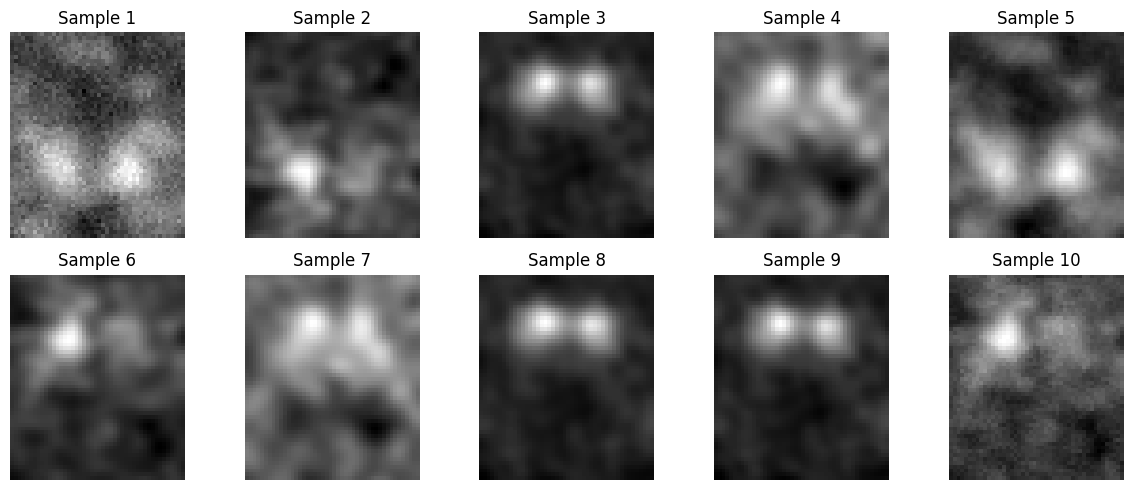

In [ ]:
# Helper function: display nifti images
def display_nifti_img(data, ax=None, title="", axis="z"):
    if axis == "x":
        slice_img = data[data.shape[0] // 2, :, :]
    elif axis == "y":
        slice_img = data[:, data.shape[1] // 2, :]
    else:
        slice_img = data[:, :, data.shape[2] // 2]

    if ax is None:
        plt.imshow(np.rot90(slice_img), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(np.rot90(slice_img), cmap='gray')
        ax.set_title(title)
        ax.axis('off')


# Helper function: Elastic Deformation (3D)
def elastic_deformation(volume, alpha, sigma):
    """Apply elastic deformation on 3D volume."""
    random_state = np.random.RandomState(None)
    shape = volume.shape

    dx = nd_gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = nd_gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = nd_gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))

    distorted = map_coordinates(volume, indices, order=1, mode='reflect')
    return distorted.reshape(shape)


# Advanced 3D Augmentation Function
def augment_volume(volume):
    """Applies advanced 3D medical augmentations."""

    aug = volume.copy().astype(np.float32)

    # 1️⃣ Rotation (small 3D rotations)
    # if random.random() < 0.7:
    #     angle = random.uniform(-10, 10)
    #     axis = random.choice([(0, 1), (1, 2), (0, 2)])
    #     aug = rotate(aug, angle=angle, axes=axis, reshape=False, order=1)

    # 2️⃣ Gaussian Noise
    if random.random() < 0.4:
        noise = np.random.normal(0, 0.02 * np.max(aug), aug.shape)
        aug += noise

    # 3️⃣ Random intensity scaling (contrast)
    if random.random() < 0.5:
        scale = random.uniform(0.9, 1.1)
        aug *= scale

    # 4️⃣ Gamma correction (non-linear intensity shift)
    if random.random() < 0.4:
        gamma = random.uniform(0.9, 1.1)
        aug_min, aug_max = aug.min(), aug.max()
        # Shift to positive domain before applying power
        if aug_max > aug_min:
            aug_norm = (aug - aug_min) / (aug_max - aug_min + 1e-8)
            aug_gamma = np.power(aug_norm, gamma)
            aug = aug_gamma * (aug_max - aug_min) + aug_min

    # 5️⃣ Gaussian blur (simulating scanner variability)
    if random.random() < 0.3:
        aug = gaussian_filter(aug, sigma=random.uniform(0.5, 1.2))

    # 6️⃣ Elastic deformation
    if random.random() < 0.2:
        aug = elastic_deformation(aug, alpha=random.uniform(30, 50), sigma=random.uniform(5, 8))

    # 7️⃣ Random flip
    if random.random() < 0.5:
        aug = np.flip(aug, axis=random.choice([0, 1, 2]))

    # 8️⃣ Adjust contrast/brightness
    if random.random() < 0.5:
        factor = random.uniform(0.9, 1.1)
        aug = np.clip(aug * factor, 0, np.max(aug))

    # Clip and normalize
    # aug = np.clip(aug, 0, np.max(aug))

    return aug


# Paths and Setup
random.seed(42)
np.random.seed(42)

csv_path = "Dataset/CSV/paired_data_datscan.csv"
imgs_dir = "Dataset/datscan_images/Paired_data_datscan"
save_csv_path = "Dataset/CSV/paired_data_datscan_augmented_v2.csv"
save_imgs_dir = "Dataset/datscan_images/Paired_data_datscan_augmented_v2"

os.makedirs(save_imgs_dir, exist_ok=True)

df = pd.read_csv(csv_path)

target_counts = {0: 50, 1: 200, 2: 753, 3: 100, 4: 50}

existing_ids = set(df["Image Data ID"].astype(str))


def generate_unique_id(existing_ids):
    while True:
        new_id = "I" + str(random.randint(1000000, 99999999))
        if new_id not in existing_ids:
            existing_ids.add(new_id)
            return new_id


# Augmentation Loop
new_rows = []
generated_volumes = []
start_time = time.time()

for nhy, target in target_counts.items():
    df_class = df[df["NHY"] == nhy].copy()
    current_count = len(df_class)

    if current_count >= target:
        continue

    n_to_generate = target - current_count
    id_pool = list(df_class["Image Data ID"].astype(str))

    for i in range(n_to_generate):
        if not id_pool:
            id_pool = list(df_class["Image Data ID"].astype(str))

        chosen_id = random.choice(id_pool)
        id_pool.remove(chosen_id)
        row = df_class[df_class["Image Data ID"] == chosen_id].iloc[0]

        patno = str(row["PATNO"])
        img_path = os.path.join(imgs_dir, patno, f"{chosen_id}.nii.gz")

        if not os.path.exists(img_path):
            continue

        vol = nib.load(img_path).get_fdata().astype(np.float32)
        aug_vol = augment_volume(vol)

        new_id = generate_unique_id(existing_ids)
        patient_folder = os.path.join(save_imgs_dir, patno) # change save_imgs_dir to imgs_dir if
        os.makedirs(patient_folder, exist_ok=True)
        out_path = os.path.join(patient_folder, f"{new_id}.nii.gz")

        nib.save(nib.Nifti1Image(aug_vol, np.eye(4)), out_path)

        new_row = row.copy()
        new_row["EVENT_ID"] = "AUGMENTED"
        new_row["Image Data ID"] = new_id
        new_rows.append(new_row)

        if len(generated_volumes) < 10:
            generated_volumes.append(aug_vol)

end_time = time.time()


# Save CSV + Display Samples
df_augmented = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
df_augmented.to_csv(save_csv_path, index=False)

print(f"✅ Generated {len(new_rows)} advanced augmented 3D images in {end_time - start_time:.2f} seconds")
print(f"✅ Augmented CSV saved at: {save_csv_path}")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    display_nifti_img(generated_volumes[i], ax=ax, title=f"Sample {i+1}")
plt.tight_layout()
plt.show()

### Adding these augmented to the original images folder

In [3]:
original_dir = "Dataset/datscan_images/bm3d_full/paired/Cropped_NIfTI"
augmented_dir = "Dataset/datscan_images/bm3d_full/paired/Cropped_NIfTI_augmented"
merged_dir = "Dataset/datscan_images/bm3d_full/paired/Cropped_NIfTI_merged"

os.makedirs(merged_dir, exist_ok=True)

# Function to copy all .nii.gz files preserving patient structure
def copy_patient_data(src_root, dest_root):
    """Copies all patient folders from src_root into dest_root, merging contents."""
    for patient_id in os.listdir(src_root):
        src_patient_path = os.path.join(src_root, patient_id)
        dest_patient_path = os.path.join(dest_root, patient_id)

        if not os.path.isdir(src_patient_path):
            continue  # skip non-folder items

        os.makedirs(dest_patient_path, exist_ok=True)

        for file in os.listdir(src_patient_path):
            if file.endswith(".nii.gz"):
                src_file = os.path.join(src_patient_path, file)
                dest_file = os.path.join(dest_patient_path, file)

                # If same file already exists, rename to avoid overwrite
                if os.path.exists(dest_file):
                    base, ext = os.path.splitext(file)
                    # handle .nii.gz properly
                    if base.endswith(".nii"):
                        base = base[:-4]
                        ext = ".nii.gz"
                    new_file = f"{base}_copy{ext}"
                    dest_file = os.path.join(dest_patient_path, new_file)

                shutil.copy2(src_file, dest_file)


# Copy original + augmented
copy_patient_data(original_dir, merged_dir)
copy_patient_data(augmented_dir, merged_dir)

print(f"\n✅ All images merged successfully into: {merged_dir}")


✅ All images merged successfully into: Dataset/datscan_images/bm3d_full/paired/Cropped_NIfTI_merged


## WGAN

In [ ]:
save_model_path  = "WGAN"

def train_wgan(
    csv_file,
    root_dir,
    epochs=80,
    batch_size=4,
    noise_dim=128,
    lr=1e-4,
    patience=10,
    n_critic=5,          # 🔹 critic updates per generator update
    clip_value=0.01,     # 🔹 weight clipping range [-c, c]
    max_batches_per_epoch=None,
):
    ds = ParkinsonsDataset(csv_file, root_dir)
    cond_dim = ds.features.shape[1]
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

    G = Generator3D(noise_dim, cond_dim).to(device)
    D = Discriminator3D(cond_dim).to(device)  # here D is now a Critic (no sigmoid at the end!)

    optG = torch.optim.RMSprop(G.parameters(), lr=lr)  # WGAN paper suggests RMSprop
    optD = torch.optim.RMSprop(D.parameters(), lr=lr)

    d_losses, g_losses = [], []

    # ---- Early Stopping Vars ----
    best_g_loss = float("inf")
    best_epoch  = 0
    patience_counter = 0

    for epoch in range(1, epochs+1):
        G.train(); D.train()
        d_running, g_running = 0.0, 0.0

        pbar = tqdm(enumerate(dl, start=1), total=len(dl), desc=f"Epoch {epoch}/{epochs}", ncols=100)

        for it, (real, cond) in pbar:
            real = real.to(device)
            cond = cond.to(device)
            B = real.size(0)

            # ========================
            #   Train Critic (D)
            # ========================
            for _ in range(n_critic):
                noise = torch.randn(B, noise_dim, device=device)
                fake = G(noise, cond).detach()

                # Critic loss = -(E[D(real)] - E[D(fake)])
                d_loss = -(torch.mean(D(real, cond)) - torch.mean(D(fake, cond)))

                optD.zero_grad()
                d_loss.backward()
                optD.step()

                # Weight clipping
                for p in D.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # ========================
            #   Train Generator (G)
            # ========================
            noise = torch.randn(B, noise_dim, device=device)
            fake = G(noise, cond)

            # Generator loss = -E[D(fake)]
            g_loss = -torch.mean(D(fake, cond))

            optG.zero_grad()
            g_loss.backward()
            optG.step()

            d_running += d_loss.item()
            g_running += g_loss.item()

            pbar.set_postfix({
                "D_loss": f"{d_loss.item():.4f}",
                "G_loss": f"{g_loss.item():.4f}"
            })

            if max_batches_per_epoch and it >= max_batches_per_epoch:
                break

        d_epoch = d_running / it
        g_epoch = g_running / it
        d_losses.append(d_epoch)
        g_losses.append(g_epoch)

        print(f"\nEpoch {epoch:03d} | D: {d_epoch:.4f} | G: {g_epoch:.4f}")

        # ---- Early Stopping Check for G ----
        if g_epoch < best_g_loss:
            best_g_loss = g_epoch
            best_epoch  = epoch
            patience_counter = 0
            os.makedirs(save_model_path + "/models", exist_ok=True)
            torch.save(G.state_dict(), f"{save_model_path}/models/Generator_best.pt")
            torch.save(D.state_dict(), f"{save_model_path}/models/Discriminator_best.pt")
            print(f"✅ New best WGAN model saved at epoch {epoch} (G_loss={g_epoch:.4f})\n")
        else:
            patience_counter += 1
            print(f"⚠️  No improvement. Patience {patience_counter}/{patience}\n")
            if patience_counter >= patience:
                print(f"\n⏹️ Early stopping at epoch {epoch}. Best epoch was {best_epoch} with G_loss={best_g_loss:.4f}\n")
                break

    # ---- Plot & save training curves ----
    os.makedirs(save_model_path + "/plots", exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(d_losses)+1), d_losses, label="Critic Loss")
    plt.plot(range(1, len(g_losses)+1), g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("WGAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_model_path}/plots/training_curves.png")
    plt.close()
    print("\nTraining curves saved.\n")

    print("✅ WGAN Training finished.")
    
    return G, D

In [6]:
# -----------------------------
# Run
# -----------------------------
G, D = train_wgan(
    csv_file=csv_path,
    root_dir=imgs_dir,
    epochs=80, # 50-100 (use 80)
    batch_size=4,
    noise_dim=128,
    lr=1e-4,
    patience=20,
    max_batches_per_epoch=None  # or e.g. 200 for quicker passes
)

[Dataset] total usable pairs: 986


Epoch 1/80: 100%|█████████████████| 247/247 [15:42<00:00,  3.82s/it, D_loss=-0.0005, G_loss=-0.4999]



Epoch 001 | D: -0.0006 | G: -0.4987
✅ New best WGAN model saved at epoch 1 (G_loss=-0.4987)



Epoch 2/80: 100%|█████████████████| 247/247 [14:24<00:00,  3.50s/it, D_loss=-0.0033, G_loss=-0.4973]



Epoch 002 | D: -0.0017 | G: -0.4986
⚠️  No improvement. Patience 1/20



Epoch 3/80: 100%|█████████████████| 247/247 [14:40<00:00,  3.56s/it, D_loss=-0.0030, G_loss=-0.4961]



Epoch 003 | D: -0.0023 | G: -0.4963
⚠️  No improvement. Patience 2/20



Epoch 4/80: 100%|█████████████████| 247/247 [15:19<00:00,  3.72s/it, D_loss=-0.0035, G_loss=-0.4951]



Epoch 004 | D: -0.0026 | G: -0.4963
⚠️  No improvement. Patience 3/20



Epoch 5/80: 100%|█████████████████| 247/247 [14:35<00:00,  3.54s/it, D_loss=-0.0021, G_loss=-0.4946]



Epoch 005 | D: -0.0027 | G: -0.4965
⚠️  No improvement. Patience 4/20



Epoch 6/80: 100%|█████████████████| 247/247 [14:14<00:00,  3.46s/it, D_loss=-0.0020, G_loss=-0.4981]



Epoch 006 | D: -0.0027 | G: -0.4974
⚠️  No improvement. Patience 5/20



Epoch 7/80: 100%|█████████████████| 247/247 [14:16<00:00,  3.47s/it, D_loss=-0.0012, G_loss=-0.4949]



Epoch 007 | D: -0.0028 | G: -0.4971
⚠️  No improvement. Patience 6/20



Epoch 8/80: 100%|█████████████████| 247/247 [14:15<00:00,  3.46s/it, D_loss=-0.0016, G_loss=-0.4966]



Epoch 008 | D: -0.0028 | G: -0.4976
⚠️  No improvement. Patience 7/20



Epoch 9/80: 100%|█████████████████| 247/247 [14:15<00:00,  3.46s/it, D_loss=-0.0013, G_loss=-0.4980]



Epoch 009 | D: -0.0029 | G: -0.4975
⚠️  No improvement. Patience 8/20



Epoch 10/80: 100%|████████████████| 247/247 [14:17<00:00,  3.47s/it, D_loss=-0.0011, G_loss=-0.4956]



Epoch 010 | D: -0.0027 | G: -0.4980
⚠️  No improvement. Patience 9/20



Epoch 11/80: 100%|████████████████| 247/247 [14:16<00:00,  3.47s/it, D_loss=-0.0029, G_loss=-0.4969]



Epoch 011 | D: -0.0029 | G: -0.4980
⚠️  No improvement. Patience 10/20



Epoch 12/80: 100%|████████████████| 247/247 [14:17<00:00,  3.47s/it, D_loss=-0.0030, G_loss=-0.4953]



Epoch 012 | D: -0.0029 | G: -0.4983
⚠️  No improvement. Patience 11/20



Epoch 13/80: 100%|████████████████| 247/247 [14:19<00:00,  3.48s/it, D_loss=-0.0036, G_loss=-0.5000]



Epoch 013 | D: -0.0030 | G: -0.4987
⚠️  No improvement. Patience 12/20



Epoch 14/80: 100%|████████████████| 247/247 [15:03<00:00,  3.66s/it, D_loss=-0.0012, G_loss=-0.4970]



Epoch 014 | D: -0.0028 | G: -0.4990
✅ New best WGAN model saved at epoch 14 (G_loss=-0.4990)



Epoch 15/80: 100%|████████████████| 247/247 [16:09<00:00,  3.92s/it, D_loss=-0.0011, G_loss=-0.5015]



Epoch 015 | D: -0.0029 | G: -0.4986
⚠️  No improvement. Patience 1/20



Epoch 16/80: 100%|████████████████| 247/247 [15:29<00:00,  3.76s/it, D_loss=-0.0003, G_loss=-0.5035]



Epoch 016 | D: -0.0030 | G: -0.4986
⚠️  No improvement. Patience 2/20



Epoch 17/80: 100%|████████████████| 247/247 [14:42<00:00,  3.57s/it, D_loss=-0.0014, G_loss=-0.4934]



Epoch 017 | D: -0.0029 | G: -0.5001
✅ New best WGAN model saved at epoch 17 (G_loss=-0.5001)



Epoch 18/80: 100%|█████████████████| 247/247 [14:01<00:00,  3.41s/it, D_loss=0.0007, G_loss=-0.4963]



Epoch 018 | D: -0.0025 | G: -0.4997
⚠️  No improvement. Patience 1/20



Epoch 19/80: 100%|████████████████| 247/247 [15:09<00:00,  3.68s/it, D_loss=-0.0056, G_loss=-0.4986]



Epoch 019 | D: -0.0025 | G: -0.5005
✅ New best WGAN model saved at epoch 19 (G_loss=-0.5005)



Epoch 20/80: 100%|████████████████| 247/247 [15:58<00:00,  3.88s/it, D_loss=-0.0064, G_loss=-0.4985]



Epoch 020 | D: -0.0026 | G: -0.4999
⚠️  No improvement. Patience 1/20



Epoch 21/80: 100%|████████████████| 247/247 [16:25<00:00,  3.99s/it, D_loss=-0.0057, G_loss=-0.5030]



Epoch 021 | D: -0.0026 | G: -0.5021
✅ New best WGAN model saved at epoch 21 (G_loss=-0.5021)



Epoch 22/80: 100%|████████████████| 247/247 [16:00<00:00,  3.89s/it, D_loss=-0.0000, G_loss=-0.5031]



Epoch 022 | D: -0.0028 | G: -0.5012
⚠️  No improvement. Patience 1/20



Epoch 23/80: 100%|████████████████| 247/247 [15:33<00:00,  3.78s/it, D_loss=-0.0068, G_loss=-0.4970]



Epoch 023 | D: -0.0022 | G: -0.5016
⚠️  No improvement. Patience 2/20



Epoch 24/80: 100%|████████████████| 247/247 [14:17<00:00,  3.47s/it, D_loss=-0.0048, G_loss=-0.4989]



Epoch 024 | D: -0.0020 | G: -0.5011
⚠️  No improvement. Patience 3/20



Epoch 25/80: 100%|████████████████| 247/247 [14:19<00:00,  3.48s/it, D_loss=-0.0046, G_loss=-0.4964]



Epoch 025 | D: -0.0025 | G: -0.5013
⚠️  No improvement. Patience 4/20



Epoch 26/80: 100%|████████████████| 247/247 [14:28<00:00,  3.52s/it, D_loss=-0.0053, G_loss=-0.5019]



Epoch 026 | D: -0.0022 | G: -0.5012
⚠️  No improvement. Patience 5/20



Epoch 27/80: 100%|████████████████| 247/247 [14:26<00:00,  3.51s/it, D_loss=-0.0010, G_loss=-0.5041]



Epoch 027 | D: -0.0025 | G: -0.5014
⚠️  No improvement. Patience 6/20



Epoch 28/80: 100%|████████████████| 247/247 [12:49<00:00,  3.12s/it, D_loss=-0.0012, G_loss=-0.5055]



Epoch 028 | D: -0.0021 | G: -0.5019
⚠️  No improvement. Patience 7/20



Epoch 29/80: 100%|█████████████████| 247/247 [12:27<00:00,  3.03s/it, D_loss=0.0001, G_loss=-0.4975]



Epoch 029 | D: -0.0022 | G: -0.4992
⚠️  No improvement. Patience 8/20



Epoch 30/80: 100%|█████████████████| 247/247 [12:02<00:00,  2.93s/it, D_loss=0.0000, G_loss=-0.5024]



Epoch 030 | D: -0.0022 | G: -0.4992
⚠️  No improvement. Patience 9/20



Epoch 31/80: 100%|█████████████████| 247/247 [12:04<00:00,  2.93s/it, D_loss=0.0002, G_loss=-0.5045]



Epoch 031 | D: -0.0020 | G: -0.5000
⚠️  No improvement. Patience 10/20



Epoch 32/80: 100%|████████████████| 247/247 [12:07<00:00,  2.95s/it, D_loss=-0.0012, G_loss=-0.4990]



Epoch 032 | D: -0.0021 | G: -0.5005
⚠️  No improvement. Patience 11/20



Epoch 33/80: 100%|████████████████| 247/247 [12:08<00:00,  2.95s/it, D_loss=-0.0005, G_loss=-0.5052]



Epoch 033 | D: -0.0021 | G: -0.5012
⚠️  No improvement. Patience 12/20



Epoch 34/80: 100%|█████████████████| 247/247 [12:06<00:00,  2.94s/it, D_loss=0.0006, G_loss=-0.5047]



Epoch 034 | D: -0.0021 | G: -0.5004
⚠️  No improvement. Patience 13/20



Epoch 35/80: 100%|████████████████| 247/247 [12:08<00:00,  2.95s/it, D_loss=-0.0016, G_loss=-0.4988]



Epoch 035 | D: -0.0020 | G: -0.5002
⚠️  No improvement. Patience 14/20



Epoch 36/80: 100%|████████████████| 247/247 [12:14<00:00,  2.97s/it, D_loss=-0.0006, G_loss=-0.5023]



Epoch 036 | D: -0.0023 | G: -0.5016
⚠️  No improvement. Patience 15/20



Epoch 37/80: 100%|████████████████| 247/247 [12:05<00:00,  2.94s/it, D_loss=-0.0014, G_loss=-0.5026]



Epoch 037 | D: -0.0023 | G: -0.5016
⚠️  No improvement. Patience 16/20



Epoch 38/80: 100%|████████████████| 247/247 [13:23<00:00,  3.25s/it, D_loss=-0.0012, G_loss=-0.5032]



Epoch 038 | D: -0.0019 | G: -0.5008
⚠️  No improvement. Patience 17/20



Epoch 39/80: 100%|████████████████| 247/247 [14:16<00:00,  3.47s/it, D_loss=-0.0028, G_loss=-0.5004]



Epoch 039 | D: -0.0016 | G: -0.5007
⚠️  No improvement. Patience 18/20



Epoch 40/80: 100%|████████████████| 247/247 [14:28<00:00,  3.52s/it, D_loss=-0.0022, G_loss=-0.4971]



Epoch 040 | D: -0.0023 | G: -0.4999
⚠️  No improvement. Patience 19/20



Epoch 41/80: 100%|████████████████| 247/247 [14:19<00:00,  3.48s/it, D_loss=-0.0002, G_loss=-0.5031]



Epoch 041 | D: -0.0019 | G: -0.4996
⚠️  No improvement. Patience 20/20


⏹️ Early stopping at epoch 41. Best epoch was 21 with G_loss=-0.5021


Training curves saved.

✅ WGAN Training finished.
